In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, json, random, math, os, sys

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import (
    Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Lambda
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop

In [2]:
# ---------------- User knobs ----------------
CSV_PATH   = "ALL_MERGED.csv"   # <--- set your CSV path
DATE_COL   = "Date"
TARGET_COL = "JKSE"
INCLUDE_TARGET_AS_FEATURE = True  # False to exclude TARGET from X
TEST_SIZE   = 0.20
VAL_SIZE    = 0.10
RANDOM_SEED = 73
MAX_EPOCHS  = 100
VERBOSE_TRAIN = 1

# Random search settings
N_TRIALS   = 50                # bump to 40–60 for deeper search
PATIENCE   = 10
WEIGHTS_BEST = "Model Weights/rs_transformer_best.weights.h5"
MODEL_BEST   = "Model Checkpoints/transformer_rs_checkpoint.keras"

N_MC  = 100
ALPHA = 0.05
USE_QUANTILES = True  # if False: Gaussian z*std

# Rolling/heatmap settings
ROLL_LEN   = 30
HEAT_WIN   = 30
HEAT_STRIDE= 10

print(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)

73


In [3]:
df = pd.read_csv(CSV_PATH)

required = [
    "Date","Nickel_Fut","Coal_Fut_Newcastle","Palm_Oil_Fut",
    "USD_IDR","CNY_IDR","EUR_IDR","BTC_USD",
    "FTSE100","HANGSENG","NIKKEI225","SNP500","DOW30","SSE_Composite","JKSE"
]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).set_index(DATE_COL)
df = df.ffill().bfill()
df

,Nickel_Fut,Coal_Fut_Newcastle,Palm_Oil_Fut,USD_IDR,CNY_IDR,EUR_IDR,BTC_USD,FTSE100,HANGSENG,NIKKEI225,SNP500,DOW30,SSE_Composite,JKSE
Date,,,,,,,,,,,,,,
2015-05-01,13750.00,62.20,2136,12962.5,2089.78,14519.9,232.078995,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-02,13750.00,62.20,2136,12962.5,2089.78,14519.9,234.929993,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-03,13750.00,62.20,2136,12962.5,2089.78,14519.9,240.358002,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-04,13750.00,62.20,2136,12980.0,2090.51,14467.5,239.018005,6986.000000,28123.82031,19531.63086,2114.489990,18070.40039,4480.463867,5140.937012
2015-05-05,14245.00,62.50,2136,13047.5,2102.39,14594.9,236.121002,6927.600098,27755.53906,19531.63086,2089.459961,17928.19922,4298.706055,5160.107422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-27,15482.88,93.75,4057,16830.0,2309.37,19127.3,93754.843750,8415.299805,21980.74023,35705.73828,5525.209961,40113.50000,3295.060059,6678.915039
2025-04-28,15637.63,95.60,3943,16855.0,2310.59,19251.8,94978.750000,8417.299805,21971.96094,35839.98828,5528.750000,40227.58984,3288.415039,6722.965820
2025-04-29,15564.00,97.25,3911,16760.0,2305.52,19082.1,94284.789060,8463.500000,22008.10938,35839.98828,5560.830078,40527.62109,3286.655029,6749.075195


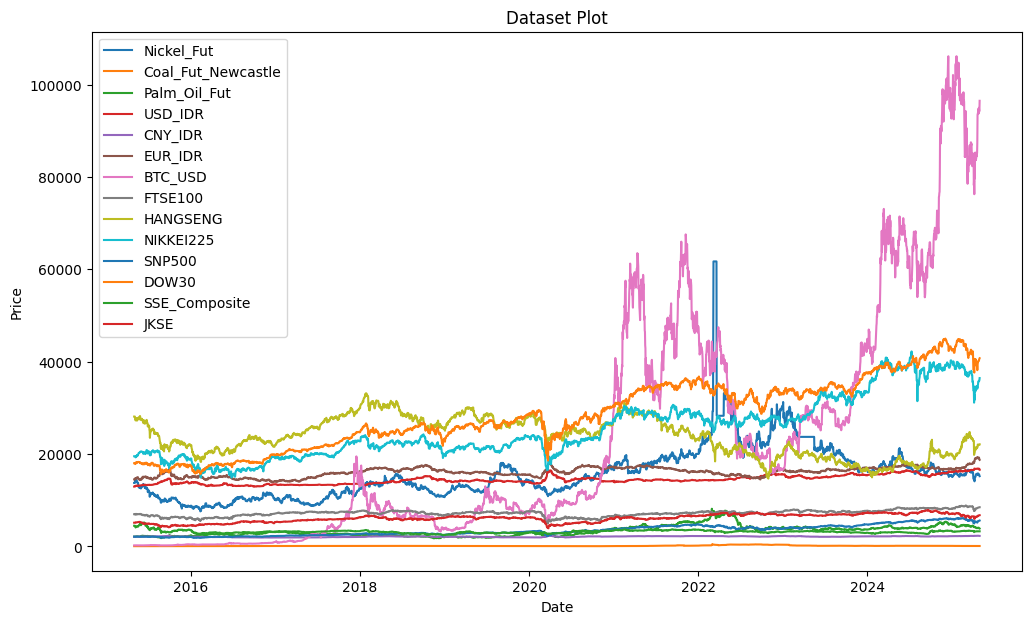

In [4]:
plt.figure(figsize=(12, 7))
plt.plot(df.index, df)
plt.title(f"Dataset Plot")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(labels=df.columns)
plt.show()

In [5]:
# ---------------- Split ----------------
n = len(df)
test_n = int(np.floor(TEST_SIZE * n))
trainval_n = n - test_n
val_n = int(np.floor(VAL_SIZE * trainval_n))
train_n = trainval_n - val_n

train_df = df.iloc[:train_n].copy()
val_df   = df.iloc[train_n:train_n + val_n].copy()
test_df  = df.iloc[train_n + val_n:].copy()

print(f"Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%) | "
      f"Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%) | "
      f"Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

Train: 2632 (72.0%) | Validation: 292 (8.0%) | Test: 730 (20.0%)


In [6]:
if INCLUDE_TARGET_AS_FEATURE:
    feature_cols = df.columns.tolist()
else:
    feature_cols = [c for c in df.columns if c != TARGET_COL]
feature_cols

['Nickel_Fut',
 'Coal_Fut_Newcastle',
 'Palm_Oil_Fut',
 'USD_IDR',
 'CNY_IDR',
 'EUR_IDR',
 'BTC_USD',
 'FTSE100',
 'HANGSENG',
 'NIKKEI225',
 'SNP500',
 'DOW30',
 'SSE_Composite',
 'JKSE']

In [7]:
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaler.fit(train_df[feature_cols])
y_scaler.fit(train_df[[TARGET_COL]])

# For inverse transform inside MC Dropout
y_mean  = float(y_scaler.mean_[0])
y_scale = float(y_scaler.scale_[0])

def scale_block(block):
    X = X_scaler.transform(block[feature_cols])
    y = y_scaler.transform(block[[TARGET_COL]])
    return (
        pd.DataFrame(X, index=block.index, columns=feature_cols),
        pd.DataFrame(y, index=block.index, columns=[TARGET_COL])
    )

X_train_s, y_train_s = scale_block(train_df)
X_val_s,   y_val_s   = scale_block(val_df)
X_test_s,  y_test_s  = scale_block(test_df)

In [8]:
# ---------------- Utilities ----------------
def make_windows(X_df, y_df, lookback: int):
    X_vals = X_df.values
    y_vals = y_df.values.squeeze()
    idx = X_df.index
    X_list, y_list, idx_list = [], [], []
    for i in range(lookback, len(X_df)):
        X_list.append(X_vals[i - lookback:i, :])
        y_list.append(y_vals[i])  # predict t using t-lookback..t-1
        idx_list.append(idx[i])
    X_arr = np.array(X_list, dtype=np.float32)
    y_arr = np.array(y_list, dtype=np.float32)
    idx_arr = np.array(idx_list)
    return X_arr, y_arr, idx_arr

def positional_encoding(length, depth):
    # depth must be even for sin/cos pairing
    if depth % 2 != 0: depth += 1
    positions = np.arange(length)[:, np.newaxis]
    dims = np.arange(depth)[np.newaxis, :]
    angle_rates = 1.0 / (10000 ** (2 * (dims//2) / depth))
    angle_rads = positions * angle_rates
    pe = np.zeros((length, depth), dtype=np.float32)
    pe[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pe[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.constant(pe)

class AddPE(tf.keras.layers.Layer):
    def __init__(self, lookback, d_model, **kwargs):
        super().__init__(**kwargs)
        self.lookback = lookback
        self.d_model = d_model
        self.pos = positional_encoding(lookback, d_model)
    def call(self, x):
        return x + self.pos

def encoder_block(x, num_heads, d_model, dff, dropout_rate):
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(
        x, x, use_causal_mask=True
    )
    x = Add()([x, Dropout(dropout_rate)(attn)])
    x = LayerNormalization(epsilon=1e-6)(x)

    ff = Dense(dff, activation="relu")(x)
    ff = Dropout(dropout_rate)(ff)
    ff = Dense(d_model)(ff)
    x = Add()([x, Dropout(dropout_rate)(ff)])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

def build_transformer(input_shape, params):
    lb = params["lookback"]
    d_model = params["d_model"]
    num_heads = params["num_heads"]
    dff = params["dff"]
    dropout = params["dropout"]

    inp = Input(shape=input_shape)
    x = Dense(d_model)(inp)
    x = AddPE(lb, d_model)(x)

    for _ in range(params["num_layers"]):
        x = encoder_block(
            x,
            num_heads=num_heads,
            d_model=d_model,
            dff=dff,
            dropout_rate=dropout
        )

    x = Lambda(lambda t: t[:, -1, :])(x)
    out = Dense(1)(x)

    model = Model(inputs=inp, outputs=out)

    # Optuna always uses Adam
    opt = Adam(learning_rate=params["lr"])
    model.compile(optimizer=opt, loss="mse")

    return model

# Make sure d_model is divisible by num_heads
def sample_divisible_pair(d_model_choices, head_choices):
    for _ in range(50):
        dm = random.choice(d_model_choices)
        nh = random.choice(head_choices)
        if dm % nh == 0:
            return dm, nh
    # fallback
    return 64, 4

def sample_params():
    lookback = random.choice([30, 45, 60, 90])
    d_model = random.choice([32, 64, 96, 128])
    valid_heads = [h for h in (2, 4, 8) if d_model % h == 0 and d_model // h >= 8]
    num_heads = random.choice(valid_heads)
    dff = random.choice([2*d_model, 3*d_model, 4*d_model])

    params = {
        "lookback": lookback,
        "d_model": d_model,
        "num_heads": num_heads,
        "dff": dff,
        "num_layers": random.choice([1, 2, 3]),
        "dropout": np.random.uniform(0.0, 0.3),
        "optimizer": "adam",
        "lr": 10 ** np.random.uniform(-4, math.log10(5e-3)),
        "batch_size": random.choice([32, 64, 128]),
        "epochs": random.choice([30, 40, 50, 60, 70, 80, 90, 100]),
        "patience": random.choice([5, 6, 7, 8, 9, 10])
    }

    return params

def compute_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return [mse, mae, rmse, mape, r2]

In [9]:
# ---------------- Random Search ----------------
best = {"val_loss": np.inf, "params": None}

print("\n=== Random Search (Transformer) begins ===")
hpo_start = time.time()  # HPO timer starts
for t in range(1, N_TRIALS + 1):
    params = sample_params()

    # Build windows with this trial's lookback
    X_tr, y_tr, _ = make_windows(X_train_s, y_train_s, params["lookback"])
    X_vl, y_vl, _ = make_windows(X_val_s,   y_val_s,   params["lookback"])

    model = build_transformer((params["lookback"], len(feature_cols)), params)

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True),
    ]

    start = time.time()
    hist = model.fit(
        X_tr, y_tr,
        validation_data=(X_vl, y_vl),
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        callbacks=callbacks,
        verbose=0
    )
    dur = time.time() - start

    val_loss = float(min(hist.history["val_loss"]))
    print(f"[Trial {t:02d}] lb={params['lookback']}, layers={params['num_layers']}, "
          f"d_model={params['d_model']}, heads={params['num_heads']}, dff={params['dff']}, "
          f"drop={params['dropout']}, opt={params['optimizer']}, lr={params['lr']}, "
          f"bs={params['batch_size']}  => val_loss={val_loss:.6f} ({dur:.1f}s)")

    if val_loss < best["val_loss"]:
        best = {"val_loss": val_loss, "params": params}
        model.save_weights(WEIGHTS_BEST)
hpo_end = time.time()  # HPO timer ends
hpo_time_s = float(hpo_end - hpo_start)
hpo_trials = N_TRIALS

print("\nBest val_loss:", best["val_loss"])
print("Best params:\n", json.dumps(best["params"], indent=2))


=== Random Search (Transformer) begins ===

[Trial 01] lb=60, layers=1, d_model=32, heads=4, dff=128, drop=0.1928069747358237, opt=adam, lr=0.0008224335253611052, bs=64  => val_loss=0.016814 (37.6s)
[Trial 02] lb=30, layers=2, d_model=128, heads=4, dff=512, drop=0.15356939473758902, opt=adam, lr=0.001088450601734486, bs=64  => val_loss=0.007307 (126.5s)
[Trial 03] lb=60, layers=1, d_model=96, heads=8, dff=192, drop=0.1478966950833575, opt=adam, lr=0.0002314006109844354, bs=128  => val_loss=0.009673 (26.0s)
[Trial 04] lb=90, layers=1, d_model=128, heads=8, dff=512, drop=0.07319400578627434, opt=adam, lr=0.0009375003516099346, bs=64  => val_loss=0.017697 (108.9s)
[Trial 05] lb=90, layers=1, d_model=64, heads=4, dff=192, drop=0.23178859911751776, opt=adam, lr=0.0003370913223832548, bs=32  => val_loss=0.020332 (59.3s)
[Trial 06] lb=30, layers=2, d_model=32, heads=4, dff=128, drop=0.12122495231776917, opt=adam, lr=0.0010326315261003302, bs=128  => val_loss=0.021515 (12.0s)
[Trial 07] lb=45

In [10]:
# ---------------- Retrain best on TRAIN+VAL & Evaluate on TEST ----------------
lb = best["params"]["lookback"]
X_trainval_s = pd.concat([X_train_s, X_val_s], axis=0)
y_trainval_s = pd.concat([y_train_s, y_val_s], axis=0)

X_trv, y_trv, _ = make_windows(X_trainval_s, y_trainval_s, lb)
X_te,  y_te,  idx_te  = make_windows(X_test_s,      y_test_s,      lb)

best_model = build_transformer((lb, len(feature_cols)), best["params"])

callbacks_final = [
    EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True),
    ModelCheckpoint(MODEL_BEST, monitor="val_loss", save_best_only=True),
    # ModelCheckpoint(WEIGHTS_BEST, monitor="val_loss", save_best_only=True, save_weights_only=True),
]

start_train = time.time()
hist_final = best_model.fit(
    X_trv, y_trv,
    validation_split=0.1,
    epochs=best["params"]["epochs"],
    batch_size=best["params"]["batch_size"],
    callbacks=callbacks_final,
    verbose=VERBOSE_TRAIN
)
end_train = time.time()
print(f"Final training time: {end_train - start_train:.2f} s")

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 10.7473 - val_loss: 0.0698
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.1405 - val_loss: 0.0650
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.1047 - val_loss: 0.0409
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0835 - val_loss: 0.0452
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0563 - val_loss: 0.0391
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0418 - val_loss: 0.0448
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0323 - val_loss: 0.0351
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0266 - val_loss: 0.0404
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0214 - val_loss: 0.0226
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0216 - val_loss: 0.0321
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0199 - val_loss: 0.0341
Epoch 12/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.

In [11]:
# Inference on test
start_test = time.time()
yhat_s = best_model.predict(X_te, verbose=1)
yhat   = y_scaler.inverse_transform(yhat_s).squeeze()
end_test = time.time()
print(f"Testing (inference) time: {end_test - start_test:.4f} s")

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Testing (inference) time: 0.7287 s


In [12]:
# Align & metrics
actual = df[TARGET_COL]
actual_test = actual.loc[idx_te]
pred_test   = pd.Series(yhat, index=idx_te, name="Pred")

mse  = mean_squared_error(actual_test.values, pred_test.values)
mae  = mean_absolute_error(actual_test.values, pred_test.values)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(actual_test.values, pred_test.values)
r2   = r2_score(actual_test.values, pred_test.values)

metrics_df = pd.DataFrame(
    [[mse, mae, rmse, mape, r2]],
    columns=["MSE", "MAE", "RMSE", "MAPE", "R²"],
    index=["Test (best cfg)"]
)
pd.set_option("display.float_format", "{:.4f}".format)
print("\n=== Metrics (Final Best Config, Transformer) ===")
print(metrics_df)


=== Metrics (Final Best Config, Transformer) ===
                        MSE      MAE     RMSE   MAPE      R²
Test (best cfg) 158767.0129 372.6674 398.4558 0.0519 -0.4239


In [13]:
# ============================================================
#  MC DROPOUT UQ FOR TRANSFORMER (RANDOM SEARCH BEST MODEL)
# ============================================================

# 1) Build windows for TRAIN, VAL, TEST with best lookback
lb = best["params"]["lookback"]

X_tr, y_tr, idx_tr = make_windows(X_train_s, y_train_s, lb)
X_vl, y_vl, idx_vl = make_windows(X_val_s,   y_val_s,   lb)
# X_te, y_te, idx_te already exist from Cell 11

# 2) Actual series per split
actual_full  = df[TARGET_COL]
actual_train = actual_full.loc[idx_tr]
actual_val   = actual_full.loc[idx_vl]
actual_test  = actual_full.loc[idx_te]  # already used above

# 3) MC Dropout forward pass helpers
@tf.function
def mc_call(m, X, training=True):
    return m(X, training=training)

def predict_mc(m, X_np, idx, n_mc=N_MC, alpha=ALPHA):
    Ys_scaled = []
    X_tf = tf.convert_to_tensor(X_np, dtype=tf.float32)

    for _ in range(n_mc):
        y_s = mc_call(m, X_tf, training=True).numpy().squeeze()
        Ys_scaled.append(y_s)

    Ys_scaled = np.stack(Ys_scaled, axis=1)     # (N, T)
    Ys = Ys_scaled * y_scale + y_mean          # inverse scaling

    mean = Ys.mean(axis=1)
    std  = Ys.std(axis=1, ddof=1)

    lower = np.quantile(Ys, q=alpha/2.0,     axis=1)
    upper = np.quantile(Ys, q=1-alpha/2.0,   axis=1)

    return (
        pd.Series(mean,  index=idx, name="mean"),
        pd.Series(lower, index=idx, name="lower"),
        pd.Series(upper, index=idx, name="upper"),
        pd.Series(std,   index=idx, name="mc_std"),
        Ys
    )

print("\n=== Running MC Dropout on Random-Search Best Transformer ===")
start_opt_mc = time.time()
mean_train, L_train, U_train, std_train, Ys_train = predict_mc(best_model, X_tr, idx_tr)
mean_val,   L_val,   U_val,   std_val,   Ys_val   = predict_mc(best_model, X_vl, idx_vl)
mean_test,  L_test,  U_test,  std_test,  Ys_test  = predict_mc(best_model, X_te, idx_te)
end_opt_mc = time.time()
print(f"[MC] Done in {end_opt_mc - start_opt_mc:.4f}s")

# 4) Base and UQ metrics
def base_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return dict(MSE=mse, MAE=mae, RMSE=rmse, MAPE=mape, R2=r2)

def uq_metrics(y_true, L, U, alpha=ALPHA):
    y = np.asarray(y_true); L = np.asarray(L); U = np.asarray(U)
    cover = (y >= L) & (y <= U)
    picp = cover.mean()
    mpiw = np.mean(U - L)
    penalty = np.where(
        y < L, (2/alpha)*(L - y),
        np.where(y > U, (2/alpha)*(y - U), 0.0)
    )
    winkler = np.mean((U - L) + penalty)
    return dict(PICP=picp, MPIW=mpiw, Winkler=winkler)

# UQ metrics per split
uq_train = uq_metrics(actual_train.values, L_train.values, U_train.values)
uq_val   = uq_metrics(actual_val.values,   L_val.values,   U_val.values)
uq_test  = uq_metrics(actual_test.values,  L_test.values,  U_test.values)

print("\n=== MC Dropout UQ Metrics (95% PI) ===")
print("Train:", uq_train)
print("Val:  ", uq_val)
print("Test: ", uq_test)

# 5) Summary table using MC mean as point forecast
rows = []
for name, a_s, m_s, L_s, U_s in [
    ("Train", actual_train, mean_train, L_train, U_train),
    ("Val",   actual_val,   mean_val,   L_val,   U_val),
    ("Test",  actual_test,  mean_test,  L_test,  U_test),
]:
    b = base_metrics(a_s.values, m_s.values)
    u = uq_metrics(a_s.values, L_s.values, U_s.values)
    rows.append({
        "Split": name,
        **{k: round(v,4) for k,v in b.items()},
        "PICP": round(u["PICP"],4),
        "MPIW": round(u["MPIW"],4),
        "Winkler": round(u["Winkler"],4),
    })

summary_mc_df = pd.DataFrame(rows)
print("\n=== Transformer (Random Search Best) + MC Dropout — Summary ===")
print(summary_mc_df.to_string(index=False))

# 6) Epistemic vs Aleatoric (approx – from test)
resid_test = actual_test.values - mean_test.values
sigma2_aleatoric = np.var(resid_test, ddof=1)

var_total_test = np.var(Ys_test, axis=1, ddof=1)
var_epistemic  = np.maximum(0.0, var_total_test - sigma2_aleatoric)
var_aleatoric  = np.full_like(var_total_test, sigma2_aleatoric)

epi_series = pd.Series(var_epistemic, index=idx_te, name="var_epistemic")
ale_series = pd.Series(var_aleatoric, index=idx_te, name="var_aleatoric")
tot_series = pd.Series(var_total_test, index=idx_te, name="var_total")

print("\nApproximate mean epistemic var (test):", epi_series.mean())
print("Approximate aleatoric var (test):", ale_series.mean())


=== Running MC Dropout on Random-Search Best Transformer ===

[MC] Done in 142.0279s

=== MC Dropout UQ Metrics (95% PI) ===
Train: {'PICP': 0.9520680324700426, 'MPIW': 237.49753002731498, 'Winkler': 313.5768351660495}
Val:   {'PICP': 0.8623481781376519, 'MPIW': 308.3924277857729, 'Winkler': 433.0658884398728}
Test:  {'PICP': 0.017518248175182483, 'MPIW': 279.69069065066134, 'Winkler': 11488.932226780913}

=== Transformer (Random Search Best) + MC Dropout — Summary ===
Split         MSE      MAE     RMSE   MAPE      R2   PICP     MPIW    Winkler
Train   3494.8819  42.5946  59.1175 0.0075  0.9930 0.9521 237.4975   313.5768
  Val  13286.0284  99.8918 115.2650 0.0144  0.4801 0.8623 308.3924   433.0659
 Test 207221.6759 428.4583 455.2161 0.0597 -0.8585 0.0175 279.6907 11488.9322

Approximate mean epistemic var (test): 0.0
Approximate aleatoric var (test): 24334.188


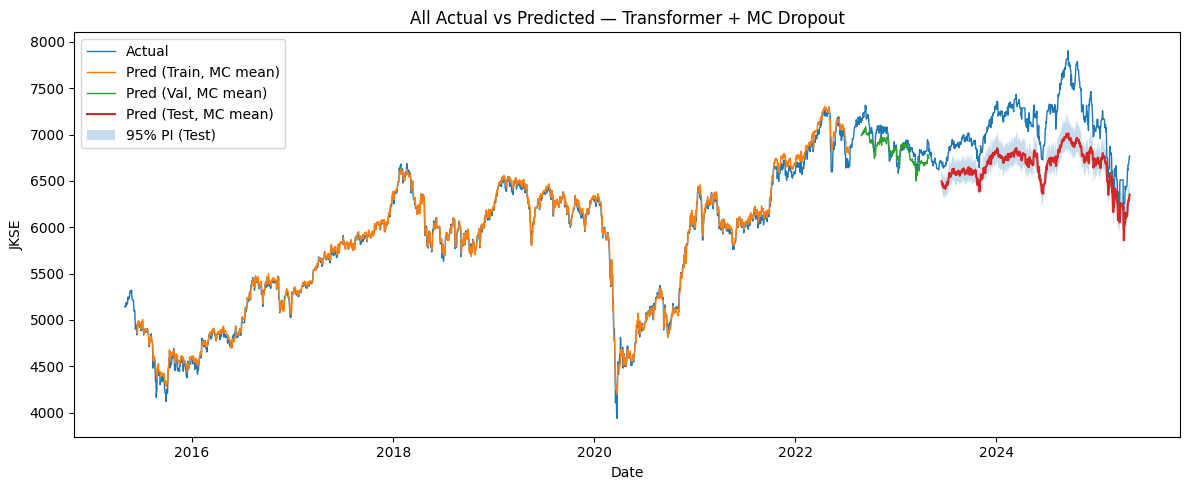

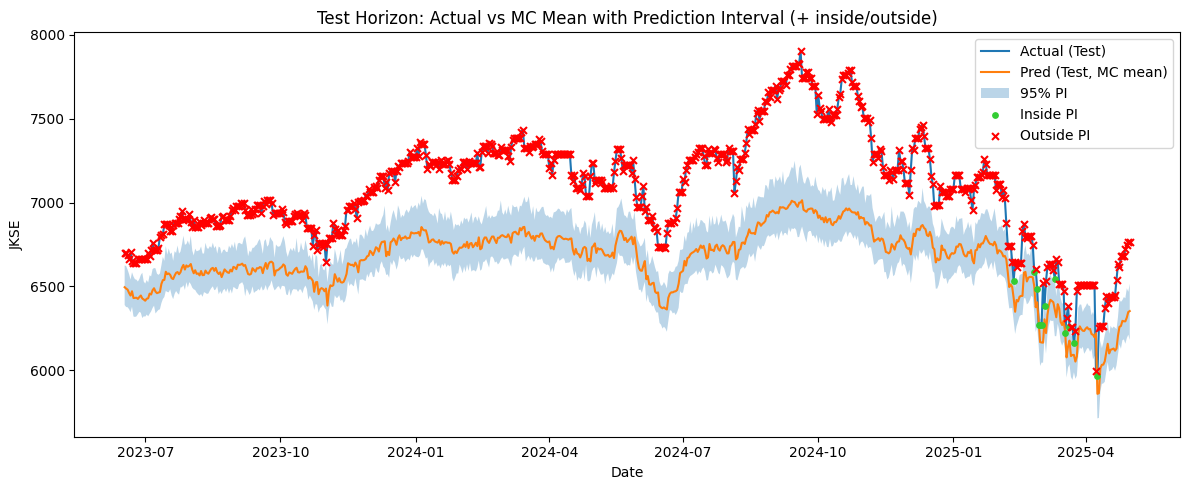

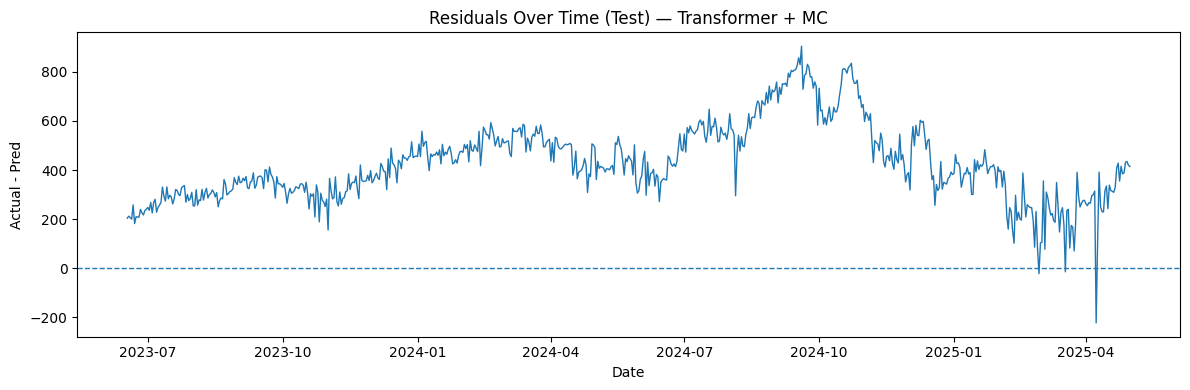

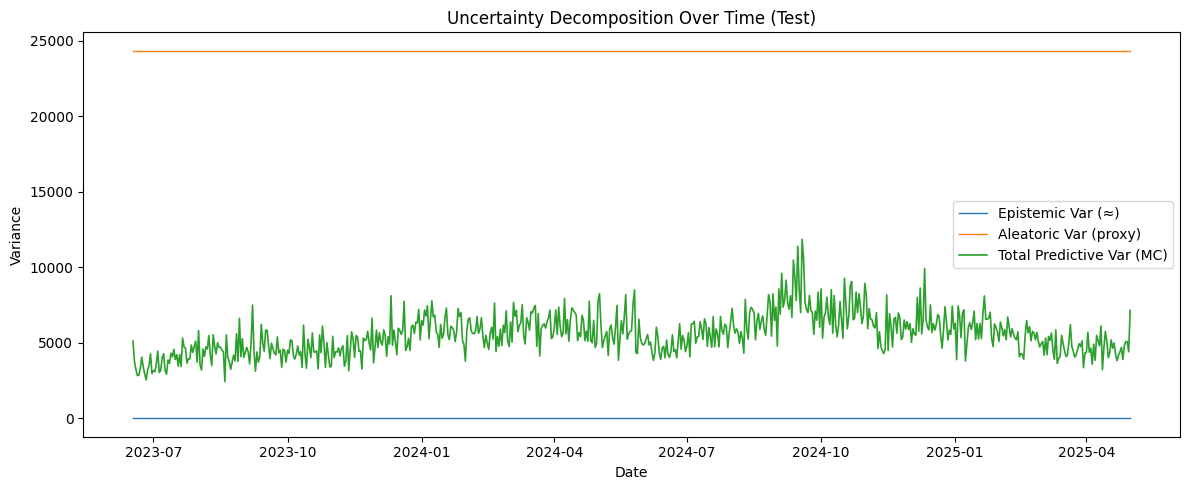

In [14]:
# ---------------------- Visualizations ----------------------
def classify_inside_outside(y_true_s, L_s, U_s):
    y = np.asarray(y_true_s); L = np.asarray(L_s); U = np.asarray(U_s)
    inside = (y >= L) & (y <= U)
    return inside, ~inside

# 1) Full series
plt.figure(figsize=(12,5))
plt.plot(actual.index, actual.values, label="Actual", linewidth=1)
plt.plot(mean_train.index, mean_train.values, label="Pred (Train, MC mean)", linewidth=1)
plt.plot(mean_val.index,   mean_val.values,   label="Pred (Val, MC mean)", linewidth=1)
plt.plot(mean_test.index,  mean_test.values,  label="Pred (Test, MC mean)", linewidth=1.5)
plt.fill_between(L_test.index, L_test.values, U_test.values, alpha=0.25, label=f"{int((1-ALPHA)*100)}% PI (Test)")
plt.title("All Actual vs Predicted — Transformer + MC Dropout")
plt.xlabel("Date"); plt.ylabel(TARGET_COL); plt.legend(); plt.tight_layout(); plt.show()

# 2) Test horizon with inside/outside markers
inside_mask, outside_mask = classify_inside_outside(actual_test.values, L_test.values, U_test.values)
plt.figure(figsize=(12,5))
plt.plot(actual_test.index, actual_test.values, label="Actual (Test)", linewidth=1.5)
plt.plot(mean_test.index,   mean_test.values,   label="Pred (Test, MC mean)", linewidth=1.5)
plt.fill_between(L_test.index, L_test.values, U_test.values, alpha=0.30, label=f"{int((1-ALPHA)*100)}% PI")
plt.scatter(actual_test.index[inside_mask],  actual_test.values[inside_mask],  s=15, label="Inside PI", zorder=3, color="limegreen")
plt.scatter(actual_test.index[outside_mask], actual_test.values[outside_mask], s=25, marker="x", label="Outside PI", zorder=3, color="red")
plt.title("Test Horizon: Actual vs MC Mean with Prediction Interval (+ inside/outside)")
plt.xlabel("Date"); plt.ylabel(TARGET_COL); plt.legend(); plt.tight_layout(); plt.show()

# 3) Residuals (test)
residuals_test = pd.Series(actual_test.values - mean_test.values, index=actual_test.index, name="Residuals")
plt.figure(figsize=(12,4))
plt.plot(residuals_test.index, residuals_test.values, linewidth=1)
plt.axhline(0, ls="--", lw=1); plt.title("Residuals Over Time (Test) — Transformer + MC")
plt.xlabel("Date"); plt.ylabel("Actual - Pred"); plt.tight_layout(); plt.show()

# 4) Uncertainty decomposition
plt.figure(figsize=(12,5))
plt.plot(epi_series.index, epi_series.values, label="Epistemic Var (≈)", linewidth=1)
plt.plot(ale_series.index, ale_series.values, label="Aleatoric Var (proxy)", linewidth=1)
plt.plot(tot_series.index, tot_series.values, label="Total Predictive Var (MC)", linewidth=1.2)
plt.title("Uncertainty Decomposition Over Time (Test)")
plt.xlabel("Date"); plt.ylabel("Variance"); plt.legend(); plt.tight_layout(); plt.show()

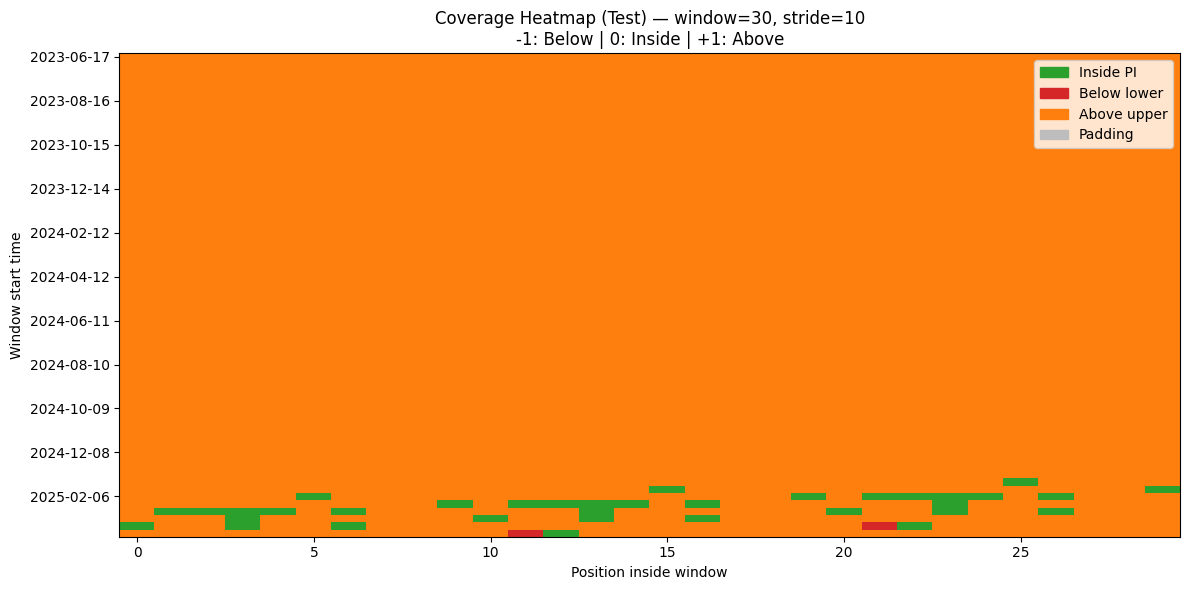

In [15]:
# ---------------------- (a) Coverage heatmap (per-window) ----------------------
from matplotlib.colors import ListedColormap, BoundaryNorm
y_true = actual_test.values; L_arr = L_test.values; U_arr = U_test.values
below_mask = (y_true < L_arr); above_mask = (y_true > U_arr); inside_mask = (y_true >= L_arr) & (y_true <= U_arr)
status = np.zeros_like(y_true, dtype=int); status[below_mask] = -1; status[above_mask] = 1
starts = np.arange(0, len(status)-HEAT_WIN+1, HEAT_STRIDE)
if len(starts) == 0: starts = np.array([0]); HEAT_WIN = len(status)
mat = []; x_tick_labels = []
for s in starts:
    e = min(s + HEAT_WIN, len(status)); row = status[s:e]
    if e - s < HEAT_WIN: row = np.pad(row, (0, HEAT_WIN - (e - s)), constant_values=np.nan)
    mat.append(row); x_tick_labels.append(actual_test.index[s].strftime('%Y-%m-%d'))
mat = np.vstack(mat)
cmap = ListedColormap(["#d62728", "#2ca02c", "#ff7f0e", "#bdbdbd"])  # red, green, orange, grey
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5]; norm = BoundaryNorm(bounds, cmap.N)
plt.figure(figsize=(12,6))
plt.imshow(mat, aspect="auto", interpolation="nearest", cmap=cmap, norm=norm)
plt.title(f"Coverage Heatmap (Test) — window={HEAT_WIN}, stride={HEAT_STRIDE}\n-1: Below | 0: Inside | +1: Above")
plt.xlabel("Position inside window"); plt.ylabel("Window start time")
yticks = np.arange(0, len(starts), max(1, len(starts)//10))
plt.yticks(yticks, [x_tick_labels[i] for i in yticks])
import matplotlib.patches as mpatches
legend_patches = [
    mpatches.Patch(color="#2ca02c", label="Inside PI"),
    mpatches.Patch(color="#d62728", label="Below lower"),
    mpatches.Patch(color="#ff7f0e", label="Above upper"),
    mpatches.Patch(color="#bdbdbd", label="Padding")
]
plt.legend(handles=legend_patches, loc="upper right", frameon=True)
plt.tight_layout(); plt.show()

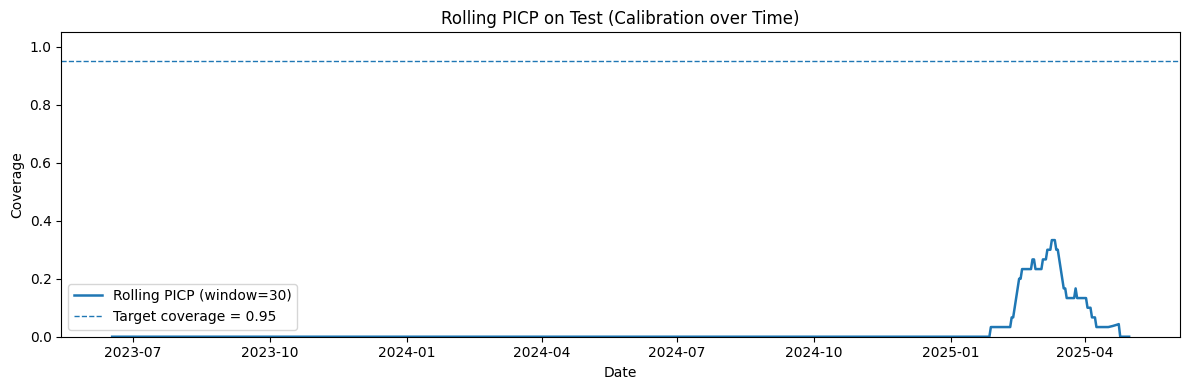

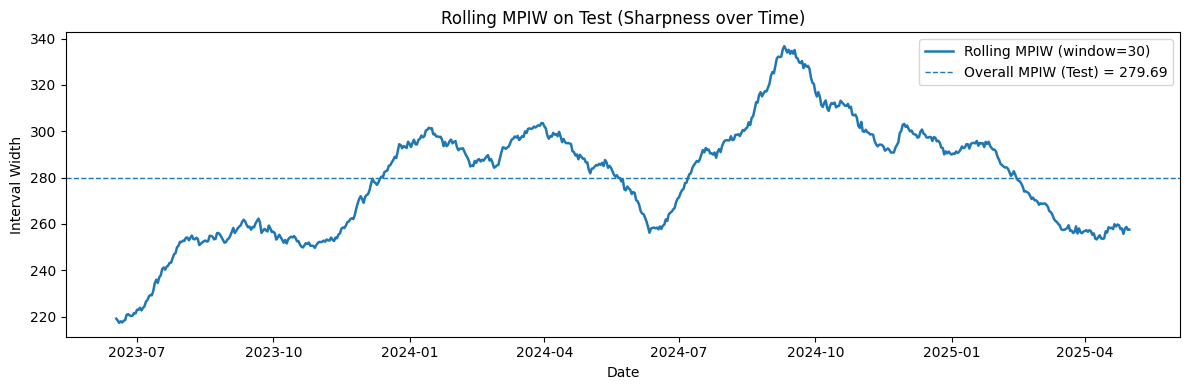

In [16]:
# ---------------------- (b) Rolling PICP & (c) Rolling MPIW ----------------------
inside_series = pd.Series(((y_true >= L_arr) & (y_true <= U_arr)).astype(int), index=actual_test.index, name="inside")
rolling_picp = inside_series.rolling(window=ROLL_LEN, center=True, min_periods=max(3, ROLL_LEN//3)).mean()
plt.figure(figsize=(12,4))
plt.plot(rolling_picp.index, rolling_picp.values, linewidth=1.8, label=f"Rolling PICP (window={ROLL_LEN})")
plt.axhline(1 - ALPHA, ls="--", lw=1, label=f"Target coverage = {1-ALPHA:.2f}")
plt.ylim(0, 1.05); plt.title("Rolling PICP on Test (Calibration over Time)")
plt.xlabel("Date"); plt.ylabel("Coverage"); plt.legend(); plt.tight_layout(); plt.show()

width_series   = pd.Series((U_arr - L_arr), index=actual_test.index, name="PI_width")
rolling_mpiw   = width_series.rolling(window=ROLL_LEN, center=True, min_periods=max(3, ROLL_LEN//3)).mean()
overall_mpiw_t = width_series.mean()
plt.figure(figsize=(12,4))
plt.plot(rolling_mpiw.index, rolling_mpiw.values, linewidth=1.8, label=f"Rolling MPIW (window={ROLL_LEN})")
plt.axhline(overall_mpiw_t, ls="--", lw=1, label=f"Overall MPIW (Test) = {overall_mpiw_t:.2f}")
plt.title("Rolling MPIW on Test (Sharpness over Time)")
plt.xlabel("Date"); plt.ylabel("Interval Width"); plt.legend(); plt.tight_layout(); plt.show()

In [17]:
# ---------------------- Compact summary table ----------------------
def table_metrics():
    def uq(y_true_s, L_s, U_s):
        y, L, U = y_true_s.values, L_s.values, U_s.values
        cover = (y >= L) & (y <= U)
        picp = cover.mean(); mpiw = np.mean(U - L)
        penalty = np.where(y < L, (2/ALPHA)*(L - y), np.where(y > U, (2/ALPHA)*(y - U), 0.0))
        winkler = np.mean((U - L) + penalty)
        return dict(PICP=picp, MPIW=mpiw, Winkler=winkler)
    rows = []
    for tag, y_true_s, y_pred_s, L_s, U_s in [
        ("Train", actual_train, mean_train, L_train, U_train),
        ("Val",   actual_val,   mean_val,   L_val,   U_val),
        ("Test",  actual_test,  mean_test,  L_test,  U_test),
    ]:
        b = base_metrics(y_true_s.values, y_pred_s.values); u = uq(y_true_s, L_s, U_s)
        rows.append({"Split": tag, **{k: round(v,4) for k,v in b.items()},
                     "PICP": round(u["PICP"],4), "MPIW": round(u["MPIW"],4), "Winkler": round(u["Winkler"],4)})
    return pd.DataFrame(rows)

summary_df = table_metrics()
print("\n=== Summary (Point + UQ) — Transformer + MC Dropout ===")
print(summary_df.to_string(index=False))


=== Summary (Point + UQ) — Transformer + MC Dropout ===
Split         MSE      MAE     RMSE   MAPE      R2   PICP     MPIW    Winkler
Train   3494.8819  42.5946  59.1175 0.0075  0.9930 0.9521 237.4975   313.5768
  Val  13286.0284  99.8918 115.2650 0.0144  0.4801 0.8623 308.3924   433.0659
 Test 207221.6759 428.4583 455.2161 0.0597 -0.8585 0.0175 279.6907 11488.9322


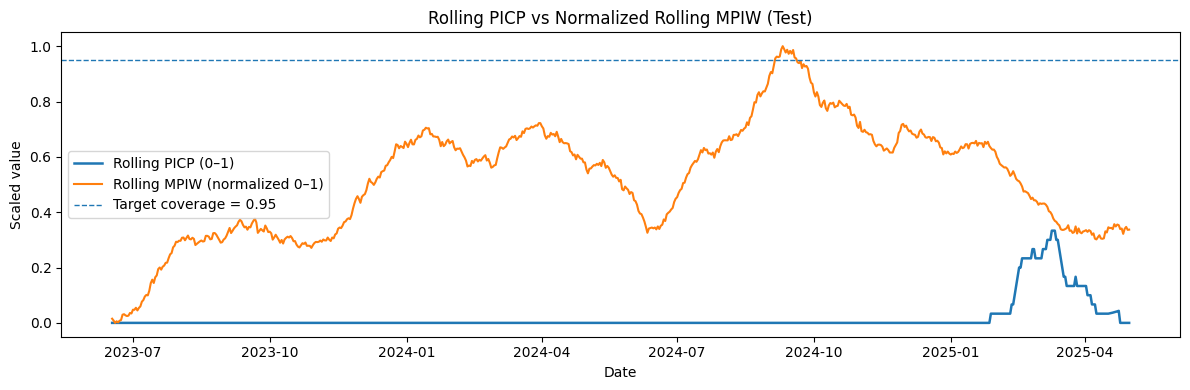

In [18]:
# (Optional) If you want a normalized comparison with Rolling PICP in a separate plot:
norm_mpiw = (rolling_mpiw - np.nanmin(rolling_mpiw)) / (np.nanmax(rolling_mpiw) - np.nanmin(rolling_mpiw) + 1e-12)
plt.figure(figsize=(12, 4))
plt.plot(rolling_picp.index, rolling_picp.values, linewidth=1.8, label="Rolling PICP (0–1)")
plt.plot(norm_mpiw.index, norm_mpiw.values, linewidth=1.5, label="Rolling MPIW (normalized 0–1)")
plt.axhline(1 - ALPHA, ls="--", lw=1, label=f"Target coverage = {1-ALPHA:.2f}")
plt.title("Rolling PICP vs Normalized Rolling MPIW (Test)")
plt.xlabel("Date"); plt.ylabel("Scaled value")
plt.legend(); plt.tight_layout(); plt.show()

In [19]:
# === CONFIGURATION ===
results_dir = os.path.join("..", "Results")
predicted_path = os.path.join(results_dir, "ALL_UQ_PREDICTED.csv")
metrics_path = os.path.join(results_dir, "ALL_UQ_METRICS.csv")

# Manual model name (since __file__ isn't available in notebooks)
model = "transformer_mcd"
model_name = f"{model}_{RANDOM_SEED}"   # change this for each notebook (e.g., GRU_Baseline)
print("Model Name for Documentation:", model_name)

# Create Results directory if not exists
os.makedirs(results_dir, exist_ok=True)

# ==========================================
# 1️⃣ PREPARE AND ALIGN TESTING DATAFRAME
# ==========================================

# Convert dates
test_dates = test_df.index.to_series().reset_index(drop=True)
actual_values = test_df[TARGET_COL].values

# If ALL_PREDICTED doesn't exist, create the base file
if not os.path.exists(predicted_path):
    print("Creating ALL_PREDICTED.csv ...")
    base_df = pd.DataFrame({
        "date": test_dates,
        "actual": actual_values
    })
    base_df.to_csv(predicted_path, index=False)

# Load and ensure datetime consistency
all_pred_df = pd.read_csv(predicted_path)
all_pred_df["date"] = pd.to_datetime(all_pred_df["date"])

# Ensure the file covers full test range (in case it was made from smaller data)
base_df = pd.DataFrame({
    "date": test_dates,
    "actual": actual_values
})
# Outer merge to make sure we have the full timeline
all_pred_df = pd.merge(base_df, all_pred_df, on=["date", "actual"], how="outer")

# Create new prediction column (aligned to date)
pred_series = pd.Series(mean_test.values, index=pd.to_datetime(idx_te), name=model_name)
pred_series = pred_series.reindex(all_pred_df["date"])  # align by date

# Create lower and upper bound series (aligned to date)
L_series = pd.Series(L_test.values, index=pd.to_datetime(idx_te), name=f"{model_name}_L")
U_series = pd.Series(U_test.values, index=pd.to_datetime(idx_te), name=f"{model_name}_U")
L_series = L_series.reindex(all_pred_df["date"])  # align by date
U_series = U_series.reindex(all_pred_df["date"])  # align by date

# Add or update the model column
all_pred_df[model_name] = pred_series.values
all_pred_df[f"{model_name}_L"] = L_series.values  # Add lower bound
all_pred_df[f"{model_name}_U"] = U_series.values  # Add upper bound

# Sort and save
all_pred_df = all_pred_df.sort_values("date").reset_index(drop=True)
all_pred_df.to_csv(predicted_path, index=False)
print(f"✅ Predictions saved to {predicted_path}")

# ==========================================
# 2️⃣ RECORD METRICS SUMMARY
# ==========================================
metrics_columns = [
    "timestamp",
    "model_name", 
    "seed",
    "mse",
    "mae",
    "rmse", 
    "mape",
    "r2_score",
    "picp",
    "mpiw",
    "winkler_score",
    "training_time_s",
    "testing_time_s", 
    "hpo_trial_s",
    "hpo_time_s"
]

# Create ALL_METRICS if missing
if not os.path.exists(metrics_path):
    print("Creating ALL_METRICS.csv ...")
    pd.DataFrame(columns=metrics_columns).to_csv(metrics_path, index=False)

# Current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Extract metrics
mse, mae, rmse, mape, r2 = base_metrics(actual_test.values, mean_test.values).values()
picp, mpiw, winkler = uq_metrics(actual_test.values, L_test.values, U_test.values, ALPHA).values()

# Build metrics row
metrics_row = {
    "timestamp": timestamp,
    "model_name": model_name,
    "seed": RANDOM_SEED,
    "mse": mse,
    "mae": mae,
    "rmse": rmse,
    "mape": mape,
    "r2_score": r2,
    "picp": picp,
    "mpiw": mpiw,
    "winkler_score": winkler,
    "training_time_s": round(end_train - start_train, 4),
    "testing_time_s": round(end_opt_mc - start_opt_mc, 4),
    "hpo_trial_s": N_TRIALS,
    "hpo_time_s": round(hpo_end - hpo_start, 4),
}

# Append metrics
all_metrics_df = pd.read_csv(metrics_path)
all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([metrics_row])], ignore_index=True)
all_metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Metrics appended to {metrics_path}")

print("\n📄 Documentation of predictions and metrics completed successfully.")


Model Name for Documentation: transformer_mcd_73
✅ Predictions saved to ..\Results\ALL_UQ_PREDICTED.csv
✅ Metrics appended to ..\Results\ALL_UQ_METRICS.csv

📄 Documentation of predictions and metrics completed successfully.
